In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhigola","key":"ca6fc2f8cf690e8b1900886e54b83af9"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c data-science-bowl-2018

 96% 343M/358M [00:02<00:00, 209MB/s]
100% 358M/358M [00:02<00:00, 170MB/s]


In [4]:
!mkdir stage1_train

In [5]:
!mkdir dataset2018

In [6]:
import zipfile
with zipfile.ZipFile('/content/data-science-bowl-2018.zip', 'r') as z:
  z.extractall('/content/dataset2018')

In [7]:
import zipfile
with zipfile.ZipFile('/content/dataset2018/stage1_train.zip', 'r') as z:
  z.extractall('/content/stage1_train')

In [8]:
!mkdir stage1_test

In [9]:
with zipfile.ZipFile('/content/dataset2018/stage1_test.zip', 'r') as z:
  z.extractall('/content/stage1_test')

In [10]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import cv2
import pickle

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize


import tensorflow as tf


# set the dimensions of the images
width = 128
height= 128
channels= 3
train_path = '/content/stage1_train/'
test_path = '/content/stage1_test/'

# get id's of folders holding each image
train_ids = os.listdir(train_path)
test_ids = os.listdir(test_path)

# set the dimensions of X_train list
X_train = np.zeros((len(train_ids), height, width, channels), dtype=np.uint8)
y_train = np.zeros((len(train_ids), height, width, 1), dtype=np.bool)

def get_data():
    global X_train, y_train
    # get training data
    for n, train_id in enumerate(train_ids):
        root_path = os.path.join(train_path + train_id)

        img_path = os.path.join(root_path + '/images/')
        mask_path = os.path.join(root_path + '/masks/')

        img_train = imread(img_path + train_id + '.png', as_gray=False)[:,:,:channels]

        img_train = resize(img_train, (height, width), preserve_range=True, mode='constant').astype(np.uint8)
        img_train= np.expand_dims(img_train, axis=0)

        X_train[n] = img_train

        mask_placeholder = np.zeros((width, height, 1), dtype=np.bool)

        for mask in os.listdir(mask_path):
            mask_ = imread(mask_path + mask)
            mask_ = resize(mask_, (height, width), preserve_range=True, mode='constant')
            mask_ = np.expand_dims(mask_, axis=-1)

            mask_placeholder = np.maximum(mask_placeholder, mask_)

        y_train[n] = mask_placeholder

    # get testing data
    X_test = np.zeros((len(test_ids), height, width, channels), dtype=np.uint8)

    for n, test_id in enumerate(test_ids):
        root_path = os.path.join(test_path + test_id)

        img_path = os.path.join(root_path + '/images/')

        img_test = imread(img_path + test_id + '.png', as_gray=False)[:,:,:channels]
        img_test = resize(img_test, (height, width), preserve_range=True, mode='constant').astype(np.uint8)

        X_test[n] = img_test

    # create training set & validation set
    X_train, X_validation = train_test_split(X_train, test_size=0.1, random_state=42, shuffle=False)

    y_train, y_validation = train_test_split(y_train, test_size=0.1, random_state=42, shuffle=False)


    return X_train, y_train, X_validation, y_validation, X_test


if __name__ == '__main__':
   X_train, y_train, X_validation, y_validation, X_test = get_data()

<ipython-input-10-c654bed6706a>:34: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train = np.zeros((len(train_ids), height, width, 1), dtype=np.bool)
<ipython-input-10-c654bed6706a>:52: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask_placeholder = np.zeros((width, height, 1), dtype=np.bool)


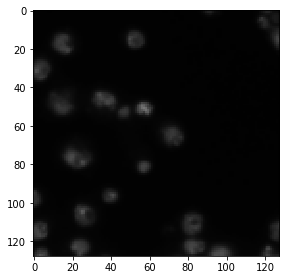

(128, 128, 1)
(128, 128)


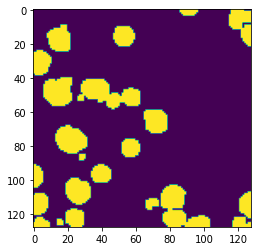

In [11]:
image_x = random.randint(0, 603)
imshow(X_train[image_x])
plt.show()
print(y_train[image_x].shape)
print(np.squeeze(y_train[image_x]).shape)
plt.imshow(np.squeeze(y_train[image_x]))
plt.show()

In [12]:
def avg_precision(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f*y_pred_f)

  return intersection/K.sum(y_pred_f)

In [13]:
def jaccard_iou(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f*y_pred_f)

  return (intersection)/(K.sum(y_true_f)+K.sum(y_pred_f)-intersection)

def jaccard_F1(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f*y_pred_f)
  return (2*intersection)/(K.sum(y_true_f)+K.sum(y_pred_f))


In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import BatchNormalization, Activation
from keras.models import Model, load_model
from keras.layers import Input, AvgPool2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

In [16]:
dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def model_build_func(x_train, y_train):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=(128,128,3), name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model
model = model_build_func(X_train, y_train)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', jaccard_iou, jaccard_F1, avg_precision])
stop_run = EarlyStopping(patience=8, verbose=1)
checkpoint_model = ModelCheckpoint('my_unet.h5', verbose=1, save_best_only=True)

results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=50, callbacks=[stop_run, checkpoint_model])

model.save("my_UNET.h5")

Epoch 1/50
34/34 [==============================] - ETA: 0s - loss: 0.4512 - acc: 0.7901 - jaccard_iou: 0.1776 - jaccard_F1: 0.2999 - avg_precision: 0.3071
Epoch 1: val_loss improved from inf to 0.62787, saving model to my_unet.h5
34/34 [==============================] - 30s 408ms/step - loss: 0.4512 - acc: 0.7901 - jaccard_iou: 0.1776 - jaccard_F1: 0.2999 - avg_precision: 0.3071 - val_loss: 0.6279 - val_acc: 0.7998 - val_jaccard_iou: 0.1252 - val_jaccard_F1: 0.2221 - val_avg_precision: 0.1853
Epoch 2/50
34/34 [==============================] - ETA: 0s - loss: 0.3340 - acc: 0.8562 - jaccard_iou: 0.2919 - jaccard_F1: 0.4480 - avg_precision: 0.4866
Epoch 2: val_loss did not improve from 0.62787
34/34 [==============================] - 7s 199ms/step - loss: 0.3340 - acc: 0.8562 - jaccard_iou: 0.2919 - jaccard_F1: 0.4480 - avg_precision: 0.4866 - val_loss: 0.6971 - val_acc: 0.8314 - val_jaccard_iou: 0.1792 - val_jaccard_F1: 0.3031 - val_avg_precision: 0.3618
Epoch 3/50
34/34 [=============

In [17]:
from tqdm import tqdm
model = tf.keras.models.load_model("my_unet.h5", custom_objects={'jaccard_iou':jaccard_iou,
                                                                 'jaccard_F1':jaccard_F1,
                                                                 'avg_precision':avg_precision})

In [18]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_validation, verbose=1)
preds_test = model.predict(X_test, verbose=1)

3/3 [==============================] - 1s 509ms/step


In [19]:
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val>0.5).astype(np.uint8)
preds_test_t = (preds_test>0.5).astype(np.uint8)

In [20]:
intersection=np.logical_and(y_validation, preds_val_t)
union=np.logical_or(y_validation, preds_val_t)
iou_score = np.sum(intersection)/np.sum(union)
print(iou_score)

0.8888674962052862


In [22]:
intersection=np.logical_and(y_validation, preds_val_t)
precision = np.sum(intersection)/np.sum(preds_val_t)
print(precision)

0.941387633549415


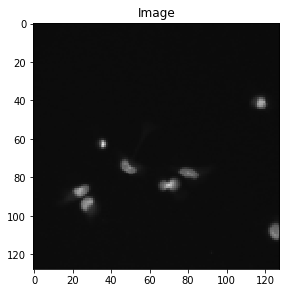

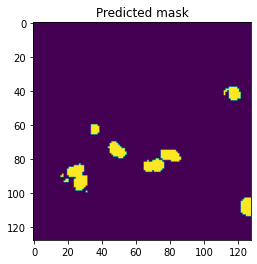

In [23]:
ix = random.randint(0, len(preds_test_t))
imshow(X_test[ix])
plt.title("Image")
plt.show()
plt.imshow(np.squeeze(preds_test_t[ix]))
plt.title("Predicted mask")
plt.show()

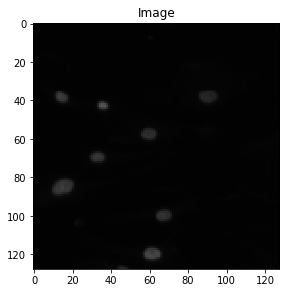

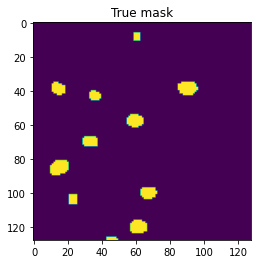

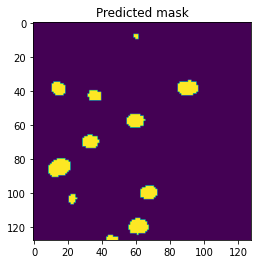

In [24]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.title("Image")
plt.show()
plt.imshow(np.squeeze(y_train[ix]))
plt.title("True mask")
plt.show()
plt.imshow(np.squeeze(preds_train_t[ix]))
plt.title("Predicted mask")
plt.show()